# Анализ эволюции Серии А

**Этот проект посвящен анализу эволюции итальянской футбольной лиги Серии А. Используются данные из SQLite-базы, исследуются таблицы, содержащие информацию о лигах и странах. Также выполняется визуализация данных.**

# Подключим необходимые библиотеки

In [9]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
database = "database_football.sqlite"

# Подключаемся к базе данных

In [10]:
conn = sqlite3.connect(database)

all_tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
print(all_tables.tbl_name.to_list())

['sqlite_sequence', 'Player_Attributes', 'Player', 'Match', 'League', 'Country', 'Team', 'Team_Attributes']


# Список стран

In [11]:
all_countries = pd.read_sql("""SELECT *
                        FROM Country;""", conn)
all_countries

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


# Список названий столбцов для таблиц "league table" и "country table"

In [12]:
league_table = pd.read_sql("""SELECT *
                        FROM league;""", conn)
country_table = pd.read_sql("""SELECT *
                        FROM country;""", conn)

print('league column names for league table',league_table.columns.to_list())
print('Country column names for country table',country_table.columns.to_list())


league column names for league table ['id', 'country_id', 'name']
Country column names for country table ['id', 'name']


# Соотнесем страну с ее лигой

In [13]:
RELATE = pd.read_sql("""select country_id,country.name as country_name,league.name as own_league_name
                     from league 
                     join country on country.id = league.country_id
                     group by country_name
                     """,conn)
RELATE.head(10)

,country_id,country_name,own_league_name
0,1,Belgium,Belgium Jupiler League
1,1729,England,England Premier League
2,4769,France,France Ligue 1
3,7809,Germany,Germany 1. Bundesliga
4,10257,Italy,Italy Serie A
5,13274,Netherlands,Netherlands Eredivisie
6,15722,Poland,Poland Ekstraklasa
7,17642,Portugal,Portugal Liga ZON Sagres
8,19694,Scotland,Scotland Premier League
9,21518,Spain,Spain LIGA BBVA


# Список названий столбцов для таблицы "Team"

In [38]:
Team_table = pd.read_sql("""SELECT *
                        FROM Team;""", conn)


print('Team column names for league table',Team_table.columns.to_list())


Team column names for league table ['id', 'team_api_id', 'team_fifa_api_id', 'team_long_name', 'team_short_name']


# Список команд

In [14]:


teams = pd.read_sql("""SELECT *
                        FROM Team
                        group by team_long_name
                        LIMIT 10;""", conn)
teams

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,16848,8350,29,1. FC Kaiserslautern,KAI
1,15624,8722,31,1. FC Köln,FCK
2,16239,8165,171,1. FC Nürnberg,NUR
3,16243,9905,169,1. FSV Mainz 05,MAI
4,11817,8576,614,AC Ajaccio,AJA
5,11074,108893,111989,AC Arles-Avignon,ARL
6,49116,6493,1714,AC Bellinzona,BEL
7,26560,10217,650,ADO Den Haag,HAA
8,9537,8583,57,AJ Auxerre,AUX
9,9547,9829,69,AS Monaco,MON


# Свяжем команы с их лигами

In [15]:

Teams_leagues = pd.read_sql(""" 

select 
country_league.countryname,
league_teams.LeagueName,
league_teams.Teamintheleague from ( select
                                          l.name as LeagueName,
                                          t.team_long_name as TeamInTheLeague
                                          from league l 
                                          join match m on l.country_id=m.country_id
                                          join team t on  m.home_team_api_id=t.team_api_id
                                          group by l.name,t.team_long_name) league_teams
                                          
                                          
                                          
join (select c.id,l.name as leagueName,c.name as countryName
                            from league l
                            join country c on c.id=l.id
                            group by c.name,l.name) country_league 
                            on 
                            league_teams.leaguename=country_league.leaguename""", conn)
Teams_leagues

,countryName,LeagueName,TeamInTheLeague
0,Belgium,Belgium Jupiler League,Beerschot AC
1,Belgium,Belgium Jupiler League,Club Brugge KV
2,Belgium,Belgium Jupiler League,FCV Dender EH
3,Belgium,Belgium Jupiler League,KAA Gent
4,Belgium,Belgium Jupiler League,KAS Eupen
...,...,...,...
291,Switzerland,Switzerland Super League,FC Zürich
292,Switzerland,Switzerland Super League,Grasshopper Club Zürich
293,Switzerland,Switzerland Super League,Lugano
294,Switzerland,Switzerland Super League,Neuchâtel Xamax


# Выведем 10 лучших игроков из топ-5 лиг

In [16]:
best_players = pd.read_sql(""" 
select 
pa.player_api_id as Player_api_id,
p.player_name as Player_Name, 
max(pa.overall_rating) as Rating,
pa.preferred_foot as Main_Foot
from player p 
join player_attributes pa on p.player_api_id=pa.player_api_id and p.player_fifa_api_id=pa.player_fifa_api_id
group by p.player_name
HAVING Rating > 90
Order by Rating DESC

""", conn)
best_players.head(10)

,Player_api_id,Player_Name,Rating,Main_Foot
0,30981,Lionel Messi,94,left
1,30829,Wayne Rooney,93,right
2,30717,Gianluigi Buffon,93,right
3,30893,Cristiano Ronaldo,93,right
4,39854,Xavi Hernandez,92,right
5,39989,Gregory Coupet,92,right
6,30626,Thierry Henry,91,right
7,30743,Ronaldinho,91,right
8,30627,John Terry,91,right
9,30657,Iker Casillas,91,left


# Матчи Серии А(Serie A — итальянский чемпионат)

In [17]:
seriea_matches = pd.read_sql("""SELECT Match.id, 
                                        Country.name AS country_name, 
                                        League.name AS league_name, 
                                        season, 
                                        stage, 
                                        date,
                                        HT.team_long_name AS  home_team,
                                        AT.team_long_name AS away_team,
                                        home_team_goal, 
                                        away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'Italy'
                                ORDER by date asc
                                LIMIT 10;""", conn)
seriea_matches

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,10264,Italy,Italy Serie A,2008/2009,1,2008-08-30 00:00:00,Sampdoria,Inter,1,1
1,10266,Italy,Italy Serie A,2008/2009,1,2008-08-30 00:00:00,Udinese,Palermo,3,1
2,10257,Italy,Italy Serie A,2008/2009,1,2008-08-31 00:00:00,Atalanta,Siena,1,0
3,10258,Italy,Italy Serie A,2008/2009,1,2008-08-31 00:00:00,Cagliari,Lazio,1,4
4,10259,Italy,Italy Serie A,2008/2009,1,2008-08-31 00:00:00,Catania,Genoa,1,0
5,10260,Italy,Italy Serie A,2008/2009,1,2008-08-31 00:00:00,Chievo Verona,Reggio Calabria,2,1
6,10261,Italy,Italy Serie A,2008/2009,1,2008-08-31 00:00:00,Fiorentina,Juventus,1,1
7,10262,Italy,Italy Serie A,2008/2009,1,2008-08-31 00:00:00,Milan,Bologna,1,2
8,10263,Italy,Italy Serie A,2008/2009,1,2008-08-31 00:00:00,Roma,Napoli,1,1
9,10265,Italy,Italy Serie A,2008/2009,1,2008-08-31 00:00:00,Torino,Lecce,3,0


# Статистика 6 лучших команд Серии А

In [19]:
Statistics_teams_season = pd.read_sql("""SELECT
                                        l.name AS League, 
                                        season,
                                        t.team_long_name,
                                        avg(home_team_goal) AS Average_goals_HOME, 
                                        avg(away_team_goal) AS Average_goals_AWAY, 
                                        avg(home_team_goal+away_team_goal) AS Average_goals, 
                                        sum(home_team_goal+away_team_goal) AS Total_goals                                       
                                FROM Match m
                                JOIN Country c on c.id = m.country_id
                                JOIN League l on l.id = m.league_id
                                LEFT JOIN Team AS t on t.team_api_id = m.home_team_api_id
                                
                                WHERE c.name  = 'Italy' AND t.team_long_name in ('Milan','Juventus','Inter','Napoli','Roma','Lazio')
                                GROUP BY  t.team_long_name,season
                                ORDER BY  t.team_long_name,season
                                ;""", conn)
Statistics_teams_season.head(10)

,League,season,team_long_name,Average_goals_HOME,Average_goals_AWAY,Average_goals,Total_goals
0,Italy Serie A,2008/2009,Inter,1.947368,0.842105,2.789474,53
1,Italy Serie A,2009/2010,Inter,2.210526,0.789474,3.000000,57
2,Italy Serie A,2010/2011,Inter,2.526316,1.052632,3.578947,68
3,Italy Serie A,2011/2012,Inter,1.888889,1.388889,3.277778,59
4,Italy Serie A,2012/2013,Inter,1.578947,1.631579,3.210526,61
5,Italy Serie A,2013/2014,Inter,1.421053,0.947368,2.368421,45
6,Italy Serie A,2014/2015,Inter,1.736842,1.210526,2.947368,56
7,Italy Serie A,2015/2016,Inter,1.526316,0.789474,2.315789,44
8,Italy Serie A,2008/2009,Juventus,2.000000,1.000000,3.000000,57
9,Italy Serie A,2009/2010,Juventus,1.684211,1.368421,3.052632,58


# Общая статистика по сезонам

In [26]:
Statistics_by_season = pd.read_sql("""SELECT c.name AS Country_Name,
                                        l.name AS league_name, 
                                        season,
                                        count(distinct stage) AS number_of_Matches,
                                        count(distinct t.team_long_name) AS number_of_teams,
                                        avg(home_team_goal) AS average_goals_HOME, 
                                        avg(away_team_goal) AS average_goals_AWAY, 
                                        avg(home_team_goal+away_team_goal) AS average_goals, 
                                        sum(home_team_goal+away_team_goal) AS Total_goals                                       
                               
                                
                                FROM Match m
                                JOIN Country c on c.id = m.country_id
                                JOIN League l on l.id = m.league_id
                                LEFT JOIN Team AS t on t.team_api_id = m.home_team_api_id
                                
                                WHERE c.name = 'Italy'
                                GROUP BY c.name, l.name, season
                                HAVING count(distinct stage) > 10
                                ORDER BY  season 
                                ;""", conn)
Statistics_by_season

,Country_Name,league_name,season,number_of_Matches,number_of_teams,average_goals_HOME,average_goals_AWAY,average_goals,Total_goals
0,Italy,Italy Serie A,2008/2009,38,20,1.521053,1.078947,2.600000,988
1,Italy,Italy Serie A,2009/2010,38,20,1.542105,1.068421,2.610526,992
2,Italy,Italy Serie A,2010/2011,38,20,1.431579,1.081579,2.513158,955
3,Italy,Italy Serie A,2011/2012,38,20,1.511173,1.072626,2.583799,925
4,Italy,Italy Serie A,2012/2013,38,20,1.494737,1.144737,2.639474,1003
5,Italy,Italy Serie A,2013/2014,38,20,1.536842,1.186842,2.723684,1035
6,Italy,Italy Serie A,2014/2015,38,20,1.498681,1.187335,2.686016,1018
7,Italy,Italy Serie A,2015/2016,38,20,1.471053,1.105263,2.576316,979


<Axes: title={'center': 'Среднее число голов за матч, забитых "гостями"'}, xlabel='season'>

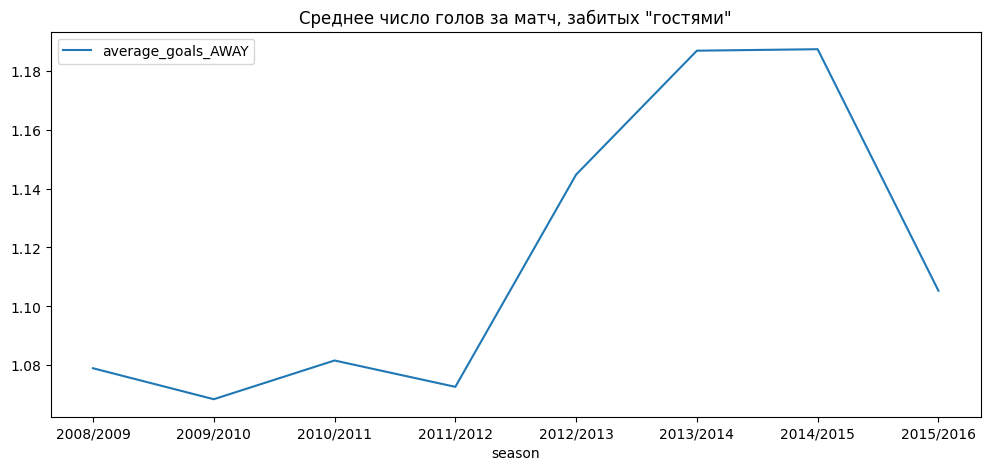

In [27]:
Statistics_by_season.plot(x='season',y=['average_goals_AWAY'],figsize=(12,5),title='Среднее число голов за матч, забитых "гостями"')

<Axes: title={'center': 'Среднее число голов за матч, забитых "хозяевами"'}, xlabel='season'>

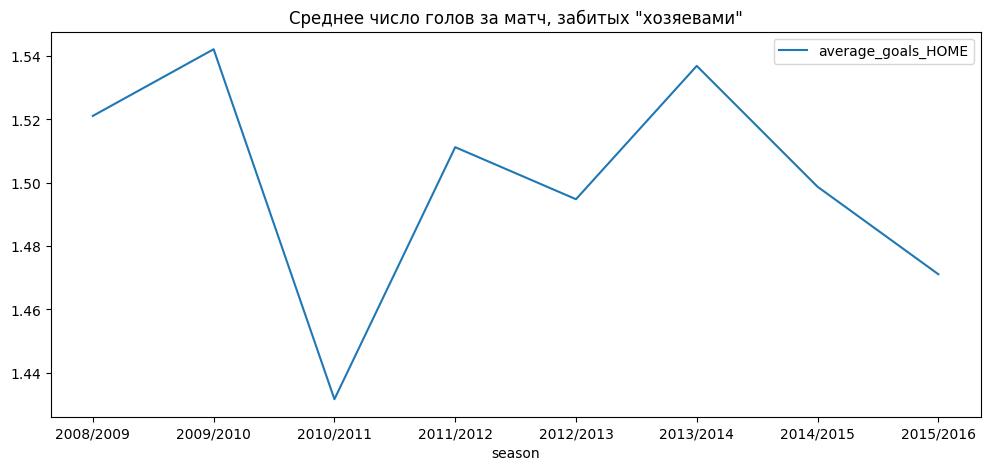

In [28]:
Statistics_by_season.plot(x='season',y=['average_goals_HOME'],figsize=(12,5),title='Среднее число голов за матч, забитых "хозяевами"')

<Axes: title={'center': 'Общее количество голов за сезон'}, xlabel='season'>

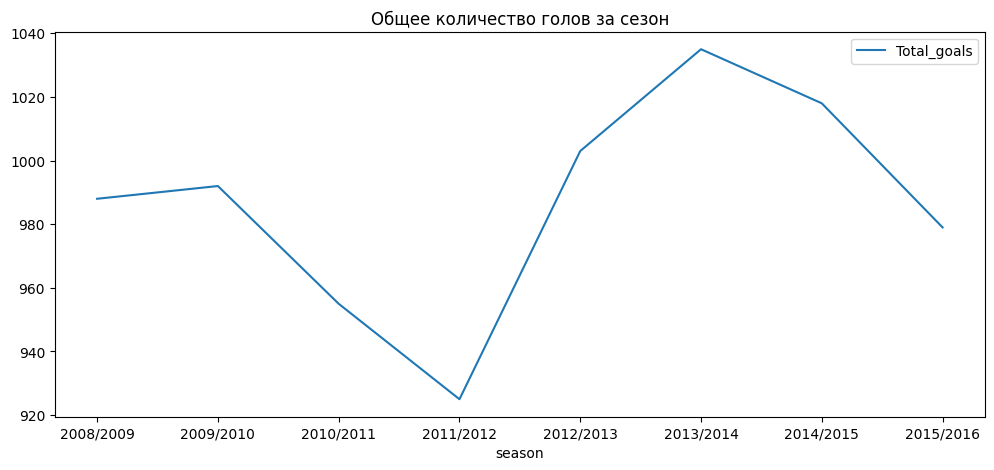

In [29]:
Statistics_by_season.plot(x='season',y=['Total_goals'],figsize=(12,5),title='Общее количество голов за сезон')

<Axes: title={'center': 'Среднее количество голов за матч'}, xlabel='season'>

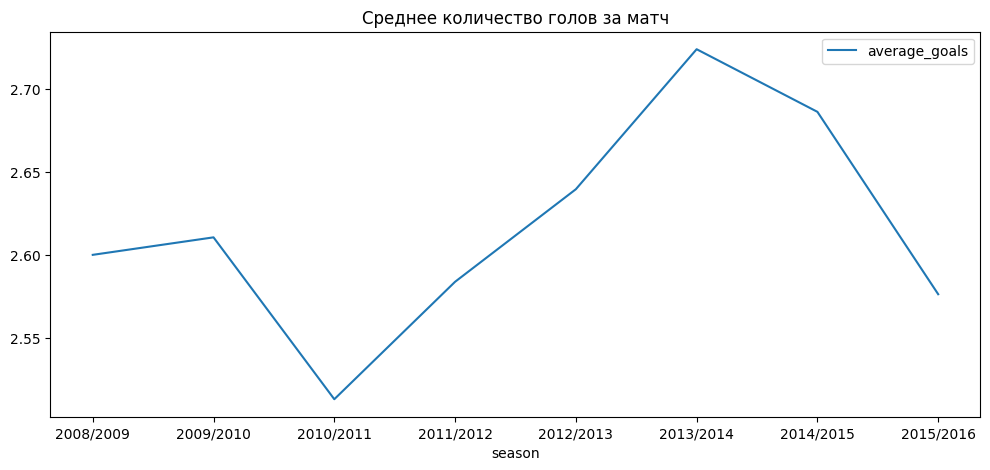

In [30]:
Statistics_by_season.plot(x='season',y=['average_goals'],figsize=(12,5),title='Среднее количество голов за матч')

# Сравнение 3-х лучших лиг Европы

In [31]:
Comparison_by_season = pd.read_sql("""SELECT c.name AS Country_Name,
                                        l.name AS league_name, 
                                        season,
                                        count(distinct stage) AS number_of_Matches,
                                        count(distinct t.team_long_name) AS number_of_teams,
                                        avg(home_team_goal) AS average_goals_HOME, 
                                        avg(away_team_goal) AS average_goals_AWAY, 
                                        avg(home_team_goal+away_team_goal) AS average_goals, 
                                        sum(home_team_goal+away_team_goal) AS Total_goals                                       
                               
                                
                                FROM Match m
                                JOIN Country c on c.id = m.country_id
                                JOIN League l on l.id = m.league_id
                                LEFT JOIN Team AS t on t.team_api_id = m.home_team_api_id
                                
                                WHERE c.name in('England','Spain','Italy') 
                                GROUP BY c.name, l.name, season
                                HAVING count(distinct stage) > 10
                                ORDER BY  season 
                                ;""", conn)
Comparison_by_season

,Country_Name,league_name,season,number_of_Matches,number_of_teams,average_goals_HOME,average_goals_AWAY,average_goals,Total_goals
0,England,England Premier League,2008/2009,38,20,1.400000,1.078947,2.478947,942
1,Italy,Italy Serie A,2008/2009,38,20,1.521053,1.078947,2.600000,988
2,Spain,Spain LIGA BBVA,2008/2009,38,20,1.660526,1.236842,2.897368,1101
3,England,England Premier League,2009/2010,38,20,1.697368,1.073684,2.771053,1053
4,Italy,Italy Serie A,2009/2010,38,20,1.542105,1.068421,2.610526,992
5,Spain,Spain LIGA BBVA,2009/2010,38,20,1.600000,1.113158,2.713158,1031
6,England,England Premier League,2010/2011,38,20,1.623684,1.173684,2.797368,1063
7,Italy,Italy Serie A,2010/2011,38,20,1.431579,1.081579,2.513158,955
8,Spain,Spain LIGA BBVA,2010/2011,38,20,1.636842,1.105263,2.742105,1042
9,England,England Premier League,2011/2012,38,20,1.589474,1.215789,2.805263,1066


<Axes: title={'center': 'Среднее количество голов за матч'}>

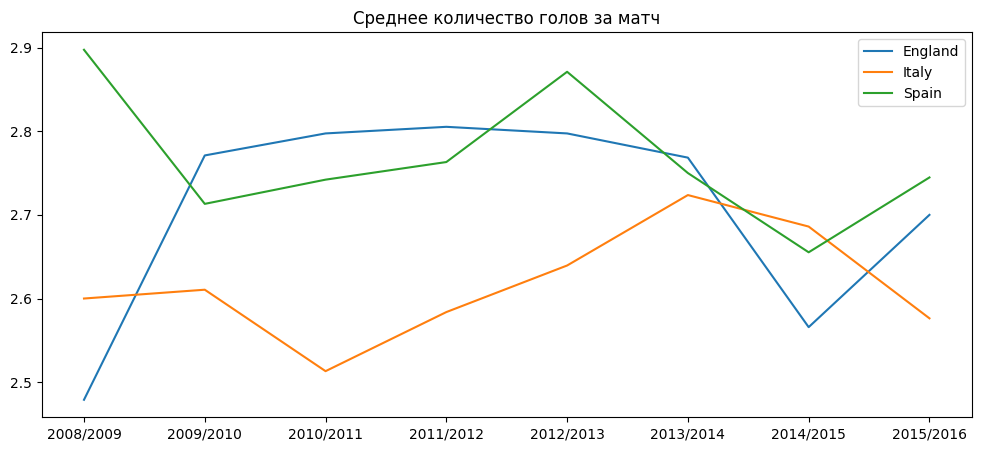

In [35]:
df = pd.DataFrame(index=np.sort(Comparison_by_season['season'].unique()), columns=Comparison_by_season['Country_Name'].unique())

df.loc[:,'England'] = list(Comparison_by_season.loc[Comparison_by_season['Country_Name']=='England','average_goals'])
df.loc[:,'Spain'] = list(Comparison_by_season.loc[Comparison_by_season['Country_Name']=='Spain','average_goals'])
df.loc[:,'Italy'] = list(Comparison_by_season.loc[Comparison_by_season['Country_Name']=='Italy','average_goals'])
df.plot(figsize=(12,5),title='Среднее количество голов за матч')

<Axes: title={'center': 'Общее число голов'}>

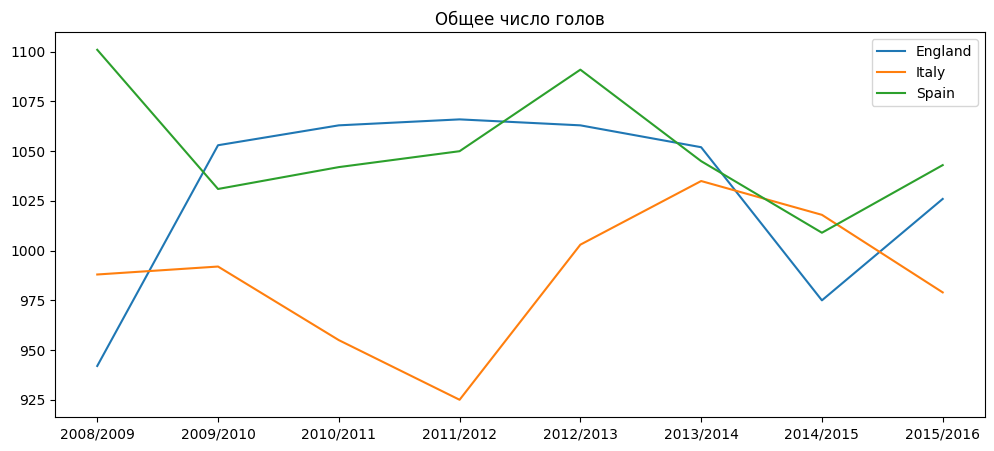

In [34]:
df = pd.DataFrame(index=np.sort(Comparison_by_season['season'].unique()), columns=Comparison_by_season['Country_Name'].unique())

df.loc[:,'England'] = list(Comparison_by_season.loc[Comparison_by_season['Country_Name']=='England','Total_goals'])
df.loc[:,'Spain'] = list(Comparison_by_season.loc[Comparison_by_season['Country_Name']=='Spain','Total_goals'])
df.loc[:,'Italy'] = list(Comparison_by_season.loc[Comparison_by_season['Country_Name']=='Italy','Total_goals'])
df.plot(figsize=(12,5),title='Общее число голов')